In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from urllib.parse import urlparse
import os
import numpy as np
from IPython.display import clear_output, display
import time
import pandas as pd

from Constants import Constants, specialTokenList, specialTokens
from All_Models import SSCL, GatedCNN, SelfAttnModel
from utils import getSampler
from LoadData import loadingData
import torch
from torch.utils.data import Dataset, DataLoader


%matplotlib inline


'''
TODO:

1. Try Larger Vocab size
4. Do Tkinter


'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




#Using inplace method for the dat

class args(object):

    # Data
    
    
    dataset = ["HSpam14", "Honeypot"][0]
    full_data = True
    usingWeightRandomSampling = True
    vocab_size = 8000 # if we create the new vocab size, we have to do the new preprocess again
    validation_portion = 0.05
    test_portion = 0.04
    random_seed = 64
    
    pickle_name = "FullPickleData"+ str(vocab_size) + "Vocab.txt"
    pickle_name_beforeMapToIdx = "FullPickleDatabeforeMapToIdx.txt"


    ##### Arch

    ## GatedCNN arch

    GatedCNN_embedingDim = 128
    GatedCNN_convDim = 64
    GatedCNN_kernel = 3
    GatedCNN_stride = 1
    GatedCNN_pad = 1
    GatedCNN_layers = 8
    GatedCNN_dropout = 0.1
        
    ## SSCL arch
    
    
    SSCL_embedingDim = 512
    SSCL_RNNHidden = 256
    SSCL_CNNDim = 256
    SSCL_CNNKernel = 5
    SSCL_CNNDropout = 0.1
    SSCL_LSTMDropout = 0.1
    SSCL_LSTMLayers = 1
    
    ## Attn arch

    SelfAttn_LenMaxSeq = 280 # Default, will be changed Later

    # These Two has to be the same
    SelfAttn_WordVecDim = 128
    SelfAttn_ModelDim = 128
    
    SelfAttn_FFInnerDim = 256
    SelfAttn_NumLayers = 3
    SelfAttn_NumHead = 4
    SelfAttn_KDim = 64
    SelfAttn_VDim = 64
    SelfAttn_Dropout = 0.1
    
    
    ## MultiTask Model
    
    FC_hidden = 16
    
    
    # Training params
    
    batch_size = 64
    L2 = 0.1
    threshold = 0.5
    lr = 0.002
    n_epoch = 50

    # If using Adam
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    
    earlyStopStep = 50000 # Set None if we don't want it
    earlyStopEpoch = 200 #

    # Logging the Training
    val_freq = 50
    val_steps = 3
    log_freq = 10
    model_save_freq = 1
    model_name = 'GatedCNN_Vocab8000_RandomWeightedSampling_WithDropout'
    model_path = './'+ dataset +'_Log/' + model_name + '/Model/'
    log_path = './' + dataset +'_Log/' + model_name + '/Log/'


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import preprocessingInputData, matchingURL, mapFromWordToIdx, CreateDatatset
import itertools
import pickle
from Constants import specialTokenList
import nltk


In [3]:
df = pd.read_html(os.path.join(args.dataset, "2thTweetsWithUserInfoSelected.html"))

In [4]:
pd.DataFrame(df[0]) # 15 columns 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,text,numberOfHashtags_c,favorite_count,retweet_count,maliciousMark,possibly_sensitive,followers_count,friends_count,description,default_profile,default_profile_image,favourites_count,listed_count,statuses_count,verified
1,That just seriously ruined my night..,0,0,0,0,NaN,173,94,cash me ousside,0,0,562,2,22545,0
2,@JessleaC I no they are so funny ..! I love yo...,0,0,0,0,NaN,129,202,NaN,1,0,1131,1,2192,0
3,@honkwas might drive so we could go subway or ...,0,0,0,0,NaN,207,372,NaN,1,0,1066,1,3426,0
4,"RT @4dize: my friends keep tellin me, that if ...",0,0,1,0,NaN,6218,915,Allah Dulu... Allah Lagi... Allah Terus...,0,0,513,44,223046,0
5,That @brad_frost post is bourne out by my expe...,0,0,0,0,NaN,282,471,Front end developer with strong interest in UX...,0,0,5452,54,5378,0
6,why tf do i keep waking up every 2 hours -.-,0,0,0,0,NaN,836,415,"G since 1996 , 2 deep with my baby [080113♡] ,...",0,0,1814,2,12523,0
7,I love playing a girl Fav song & watch them go...,0,0,0,0,NaN,3301,1113,NaN,0,0,60,9,26644,0
8,Yup late bout to write some music. Working on ...,1,2,1,0,NaN,444,331,Alive Forever. LW. Cloudie EP out now!,0,0,11964,3,10852,0
9,RT @2PM_facts: RT @jypnation [2PM LIVE TOUR in...,0,0,5,0,NaN,451,277,"legend fans, are you okay? im not",0,0,9,1,24706,0


In [5]:
columnNames = list(df[0].loc[0])

In [6]:
df = df[0].iloc[1:, :]

In [7]:
df.columns = columnNames

In [8]:
df.drop(['description'], axis = 1, inplace = True)

In [9]:
# X_train, X_test, Y_train, Y_test = train_test_split(df.drop('maliciousMark', axis = 1), df['maliciousMark'], test_size=args.validation_portion , random_state=args.random_seed)
# X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size=args.test_portion, random_state=args.random_seed)

# # stratify=df['maliciousMark'], stratify=Y_test

In [10]:
from nltk.tokenize import TweetTokenizer
import re
def preprocessingInputTextData(colName):
    input = df[colName]
    ps = nltk.stem.PorterStemmer()
    tknzr = TweetTokenizer()
    allText = [i for i in input]
    preprocessedText = [[ps.stem(word) for word in tknzr.tokenize(re.sub(r'\d+', '', re.sub(r"http\S+|www.\S+", matchingURL,
                                                                                            sentence)).lower()) if word not in nltk.corpus.stopwords.words('english') and len(word) >= 3] for sentence in allText]
    df[colName] = preprocessedText


In [11]:
from collections import defaultdict

In [12]:
preprocessingStra = defaultdict(dict)

In [13]:
class filling_method():
    MOST_COMMON = "MOST_COMMON"
    MEAN = "MEAN"
    CERTAIN_VALUE = "CERTAIN_VALUE"

In [14]:
# should I use the inplace method or the return?

def fillingNullValue(colName):   
    if preprocessingStra[colName]['fillingNullMethod'] == filling_method.MOST_COMMON:
        df[colName] = df[colName].astype('float')
        df[colName].fillna(df[colName].mean(), inplace=True)
    elif preprocessingStra[colName]['fillingNullMethod'] == filling_method.MEAN:
        df[colName] = df[colName].astype('category')
        df[colName].fillna(df[colName].astype(
            'category').describe()['top'], inplace=True)
    elif preprocessingStra[colName]['fillingNullMethod'] == filling_method.CERTAIN_VALUE:
        df[colName] = df[colName].astype('category')
        df[colName] = df[colName].cat.add_categories(
            [preprocessingStra[colName]['fillingNullValue']])
        df[colName].fillna(preprocessingStra[colName]
                           ['fillingNullValue'], inplace=True)

In [15]:
preprocessingStra['text']['steps'] = [preprocessingInputTextData]
preprocessingStra["numberOfHashtags_c"]['steps']  = [None]
preprocessingStra['favorite_count']['steps'] = [None]
preprocessingStra['retweet_count']['steps'] = [None]
preprocessingStra['possibly_sensitive'] = {
    'fillingNullMethod': filling_method.CERTAIN_VALUE,
    'fillingNullValue': 'UNKNOWN',
    'steps': [fillingNullValue],
}
preprocessingStra['followers_count']['steps'] = [None]
preprocessingStra['friends_count']['steps'] = [None]
# preprocessingStra['description']= {
#    'steps': [ fillingNullValue,preprocessingInputTextData],
#     'fillingNullMethod': filling_method.CERTAIN_VALUE,
#     'fillingNullValue': 'NULLDescription'
# } 
preprocessingStra['default_profile']['steps'] = [None]
preprocessingStra['default_profile_image']['steps'] = [None]
preprocessingStra['favourites_count']['steps'] = [None]
preprocessingStra['listed_count']['steps'] = [None]
preprocessingStra['statuses_count']['steps'] =[None] 
preprocessingStra['verified']['steps'] = [None]

In [16]:
def TweetsWithUserInfoPreprocessing():
    for colName in preprocessingStra.keys():
        for step in preprocessingStra[colName]['steps']:
            print(colName, ':', step)
            if not step is None:
                step(colName)
    return df

In [17]:
newdf = TweetsWithUserInfoPreprocessing()

text : <function preprocessingInputTextData at 0x7f3ad2fd7f28>
numberOfHashtags_c : None
favorite_count : None
retweet_count : None
possibly_sensitive : <function fillingNullValue at 0x7f3ad2f4a510>
followers_count : None
friends_count : None
default_profile : None
default_profile_image : None
favourites_count : None
listed_count : None
statuses_count : None
verified : None


In [18]:
df = pd.get_dummies(df, drop_first = True, columns=['possibly_sensitive', 'default_profile', 'default_profile_image', 'verified'] )

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('maliciousMark', axis = 1), df['maliciousMark'], test_size=args.validation_portion ,stratify=df['maliciousMark'],  random_state=args.random_seed)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size=args.test_portion, stratify=Y_test,random_state=args.random_seed)

In [20]:
len(X_train)

1900

In [21]:
tweets_text = nltk.Text(list(itertools.chain(*X_train['text'])))


In [22]:
args.tweets_vocab_size = 2000


In [23]:
from Constants import specialTokenList

In [24]:
if args.tweets_vocab_size:  
    tweets_text.tokens = specialTokenList + \
        [w for w, _ in tweets_text.vocab().most_common(
            args.tweets_vocab_size - len(specialTokenList))]


In [25]:
len(tweets_text.tokens)

2000

In [26]:
def mapFromWordToIdx(input, text):
    '''
    Using text, so it will be changed once we update the text
    '''
    wholeText = []

    for s in input:
        sentence = [2]
        for w in s:
            if w in text.tokens:
                sentence.append(text.index(w))
            else:
                sentence.append(1)
        sentence.append(3)
        wholeText.append(sentence)

    return wholeText

In [27]:
X_train['text'] = mapFromWordToIdx(X_train['text'], tweets_text)
X_validation['text'] = mapFromWordToIdx(X_validation['text'], tweets_text)
X_test['text'] = mapFromWordToIdx(X_test['text'], tweets_text)


In [28]:
df.columns

Index(['text', 'numberOfHashtags_c', 'favorite_count', 'retweet_count',
       'maliciousMark', 'followers_count', 'friends_count', 'favourites_count',
       'listed_count', 'statuses_count', 'possibly_sensitive_1',
       'possibly_sensitive_UNKNOWN', 'default_profile_1',
       'default_profile_image_1', 'verified_1'],
      dtype='object')

In [29]:
class TweetsWithUserInfoDataset(Dataset):
    def __init__(self, text_p, X_ordered, text_len, y_ordered):
        super(TweetsWithUserInfoDataset, self).__init__()

        self.text_p = text_p
        self.X_ordered = X_ordered
        self.text_len = text_len
        self.y_ordered = y_ordered

    def __len__(self,):
        return len(self.y_ordered)

    def __getitem__(self, idx):
        return self.text_p[idx], self.X_ordered[idx], self.text_len[idx], self.y_ordered[idx]

In [30]:
from torch.nn.utils.rnn import pad_sequence

In [31]:
def CreateTweetsWithUserInfoDatatset(X, y):
    '''
    At these step two kind of the sequential data has to be coped with, twitter text and 
    '''
    text_len = torch.tensor(list(map(len, X['text'])))
    text_len, text_len_idx = text_len.sort(0, descending=True)
    
    text_ordered = []
    text_ordered = [torch.LongTensor(list(X['text'])[i.item()]) for i in text_len_idx]
    X_ordered = torch.FloatTensor([list(map(float, list(X.drop(['text'], axis = 1).iloc[i.item(),:]))) for i in text_len_idx])
    y_ordered = torch.FloatTensor(np.array([y[i] for i in text_len_idx]))
    text_p = pad_sequence(text_ordered, batch_first=True)
    dataset = TweetsWithUserInfoDataset(text_p, X_ordered, text_len, y_ordered)

    return dataset

In [32]:
training_dataset = CreateTweetsWithUserInfoDatatset(X_train, list(map(int, list(Y_train))))
validation_dataset = CreateTweetsWithUserInfoDatatset(X_validation, list(map(int, list(Y_validation))))
train_dataset = CreateTweetsWithUserInfoDatatset(X_train, list(map(int, list(Y_train))))

In [33]:
td = train_dataset[0]

In [34]:
td

(tensor([   2,    1,  100,  120,    1, 1549,  112,   60,    1,   35,  213,  196,
          275,  213,   36,    1,   86,  205,  214,   98, 1017,    3]),
 tensor([0.0000e+00, 0.0000e+00, 4.0000e+00, 1.3290e+03, 2.2520e+03, 2.8697e+04,
         8.7000e+01, 3.1909e+04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]),
 tensor(22),
 tensor(0.))

In [35]:
 k = (4,5)

In [36]:
type(k) == tuple

True

In [37]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from torch.nn.utils import clip_grad_norm
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy

import matplotlib

In [38]:
args.num_extra_info = len(X_train.drop(['text'], axis = 1).columns)
args.num_features = len(X_train.columns)

In [39]:
a = torch.randn(64,1)

In [40]:
b  = torch.randn(64, 15)

In [41]:
a.size()

torch.Size([64, 1])

In [42]:
torch.cat((a,b),dim = 1).size()

torch.Size([64, 16])

In [43]:
class MultiTaskModel(nn.Module):
    
    def __init__(self, textModel, args):
        super(MultiTaskModel, self).__init__()
        
        self.textModel = textModel(args)
        
        self.infoModel = nn.Sequential(
            nn.Linear(args.num_features, args.FC_hidden),
            nn.BatchNorm1d(args.FC_hidden),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.FC_hidden, args.FC_hidden),
            nn.BatchNorm1d(args.FC_hidden),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.FC_hidden, args.FC_hidden),
            nn.BatchNorm1d(args.FC_hidden),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.FC_hidden, 1),
        )
        
        
    def forward(self, input, length):
        
        args.gggg = input
        
        text_input, extra_info = input
        
        text_out = self.textModel(text_input, length)
        
        return self.infoModel(torch.cat((text_out, extra_info), dim = 1))
        
        
        

In [44]:
from All_Models import GatedCNN

In [45]:
# Put it after the training set
args.numberOfSpammer = sum([t[-1] for t in training_dataset])
args.numberOfNonSpammer = len(training_dataset)-args.numberOfSpammer
args.len_max_seq = training_dataset[0][2]

print("Number of Spammer: ", args.numberOfSpammer)
print("Number of NonSpammer: ", args.numberOfNonSpammer)

Number of Spammer:  tensor(196.)
Number of NonSpammer:  tensor(1704.)


In [46]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from torch.nn.utils import clip_grad_norm
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy

import matplotlib



class Trainer(nn.Module):

    def __init__(self, model, args):
        super(Trainer, self).__init__()

        self.model = MultiTaskModel(model, args)
        self.optim = optim.Adam(
            self.model.parameters(), lr=args.lr, weight_decay=args.L2)

        if args.usingWeightRandomSampling:
            pos_weight = None
        else:
            pos_weight = torch.tensor(
                args.numberOfNonSpammer/args.numberOfSpammer)

        self.threshold = args.threshold
        self.log_path = args.log_path
        self.model_path = args.model_path
        self.model_name = args.model_name

        self.Loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.hist = defaultdict(list)
        self.cms = defaultdict(list)
        self.confusion_matrics = []
        
        self.apply(self.weight_init)


    def forward(self, input, label):

        if type(input) is tuple:
            input, lengths = input
        else:
            lengths = None

        self.pred = self.model(input, lengths)
        self.label = label
        loss = self.Loss(self.pred.squeeze(1), label)

        accuracy = torch.mean(
            ((torch.sigmoid(self.pred) > self.threshold).squeeze(-1) == label.byte()).float())

        cm = confusion_matrix(label.cpu().numpy(),
                              (torch.sigmoid(self.pred) > self.threshold).cpu().numpy())

        return loss, accuracy, cm

    def train_step(self, input, label):

        self.optim.zero_grad()

        self.loss, self.accuracy, self.cm = self.forward(input, label)

        self.hist["Temp_Train_Loss"].append(self.loss.item())
        self.hist["Temp_Train_Accuracy"].append(self.accuracy.item())
        self.hist["Train_Loss"].append(self.loss.item())
        self.hist["Train_Accuracy"].append(self.accuracy.item())
        self.cms["Train"].append(self.cm)
        self.cms["Train"] = self.cms["Train"][-10:]
        self.loss.backward()
        # clip_grad_norm(self.model.parameters(), 0.25)
        self.optim.step()

        return self.loss, self.accuracy, self.cm

    def test_step(self, input, label, validation=True):

        # Not Updating the weight

        self.loss, self.accuracy, self.cm = self.forward(input, label)

        if validation:
            self.hist["Temp_Val_Loss"].append(self.loss.item())
            self.hist["Temp_Val_Accuracy"].append(self.accuracy.item())
            self.hist["Val_Loss"].append(self.loss.item())
            self.hist["Val_Accuracy"].append(self.accuracy.item())
            self.cms["Val"].append(self.cm)
            self.cms["Val"] = self.cms["Val"][-10:]
        else:
            self.hist["Temp_Test_Loss"].append(self.loss.item())
            self.hist["Temp_Test_Accuracy"].append(self.accuracy.item())
            self.hist["Test_Loss"].append(self.loss.item())
            self.hist["Test_Accuracy"].append(self.accuracy.item())
            self.cms["Test"].append(self.cm)
            self.cms["Test"] = self.cms["Test"][-10:]

        return self.loss, self.accuracy, self.cm

    def calculateAverage(self,):

        temp_keys = deepcopy(list(self.hist.keys()))
        for name in temp_keys:
            if 'Temp' in name:
                self.hist["Average" + name[4:]
                          ].append(sum(self.hist[name])/len(self.hist[name]))
                self.hist[name] = []

    def plot_train_hist(self, step):

        fig = plt.figure(figsize=(20, 10))
        num_loss = 2
        i = 0
        for name in self.hist.keys():
            if 'Train' in name and not "Temp" in name and not "Average" in name:
                i += 1
                fig.add_subplot(num_loss, 1, i)
                plt.plot(self.hist[name], label=name)
                plt.xlabel('Number of Steps', fontsize=15)
                plt.ylabel(name, fontsize=15)
                plt.title(name, fontsize=30, fontweight="bold")
                plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

        fig.savefig(self.log_path+"Train_Loss&Acc_Hist_"+str(step)+".png")

    def plot_all(self, step=None):

        fig = plt.figure(figsize=(20, 10))
        for name in self.hist.keys():
            if "Average" in name:
                if 'Loss' in name:
                    plt.subplot(211)
                    plt.plot(self.hist[name], marker='o', label=name)
                    plt.ylabel('Loss', fontsize=15)
                    plt.xlabel('Number of epochs', fontsize=15)
                    plt.title('Loss', fontsize=20, fontweight="bold")
                    plt.legend(loc='upper left')
                if "Accuracy" in name:
                    plt.subplot(212)
                    plt.plot(self.hist[name], marker='o', label=name)
                    plt.ylabel('Accuracy', fontsize=15)
                    plt.xlabel('Number of epochs', fontsize=15)
                    plt.title('Accuracy', fontsize=20, fontweight="bold")
                    plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

        if step is not None:
            fig.savefig(self.log_path + "All_Hist_"+str(step)+".png")

    def model_save(self, step):

        path = self.model_path + self.model_name+'_Step_' + str(step) + '.pth'
        torch.save({self.model_name: self.state_dict()}, path)
        print('Model Saved')

    def load_step_dict(self, step):

        path = self.model_path + self.model_name + \
            '_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(
            path, map_location=lambda storage, loc: storage)[self.model_name])
        print('Model Loaded')

    def num_all_params(self,):
        return sum([param.nelement() for param in self.parameters()])
    
    
    def weight_init(self, m):

        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear, nn.Conv1d]:
            nn.init.kaiming_normal_(m.weight, 0.2, nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name:
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()

In [47]:
if args.usingWeightRandomSampling:
    sampler = getSampler(training_dataset)
else:
    sampler = None

train_loader = DataLoader(
    training_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False, sampler = sampler)
valid_loader = DataLoader(
    validation_dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)

trainer = Trainer(GatedCNN, args).to(device)

print("Number of Parameters in this Model: ",trainer.num_all_params())
print("Using device: ", device)

scheduler = optim.lr_scheduler.StepLR(trainer.optim, 2000, gamma=0.85)
# trainer.optim.param_groups[0]['lr']=
allStep = 0
epoch = 0

/home/chihcheng/python3env/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


Number of Parameters in this Model:  1273922
Using device:  cuda


In [48]:
print("Model Structure: \n", trainer.model)

Model Structure: 
 MultiTaskModel(
  (textModel): GatedCNN(
    (emb): Embedding(8000, 128)
    (conv): ModuleList(
      (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace)
        (3): Dropout(p=0.1)
      )
      (2): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace)
        (3): Dropout(p=0.1)
      )
      (3): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace)
        (3): Drop

TrainConfusion Matrix: 



,0,1
0,13,5
1,8,18


ValConfusion Matrix: 



,0,1
0,18,0
1,26,0


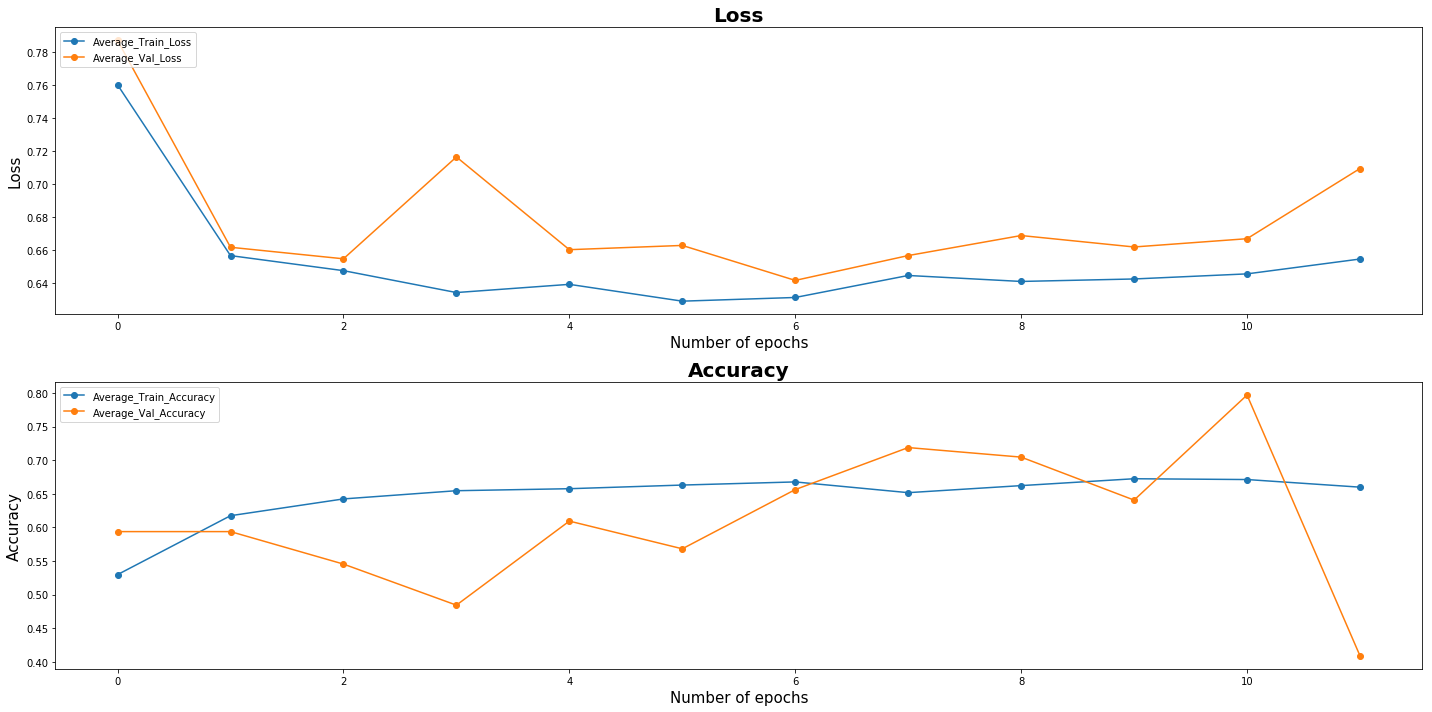

Model Saved
| Epoch [20] | Step [601] | lr [0.002000] | Loss: [0.6349] | Acc: [0.7031] | Time: 0.0s
| Epoch [20] | Step [602] | lr [0.002000] | Loss: [0.6257] | Acc: [0.7969] | Time: 0.0s
| Epoch [20] | Step [603] | lr [0.002000] | Loss: [0.6906] | Acc: [0.5625] | Time: 0.0s
| Epoch [20] | Step [604] | lr [0.002000] | Loss: [0.6537] | Acc: [0.6406] | Time: 0.0s
| Epoch [20] | Step [605] | lr [0.002000] | Loss: [0.6584] | Acc: [0.6875] | Time: 0.0s
| Epoch [20] | Step [606] | lr [0.002000] | Loss: [0.6349] | Acc: [0.7188] | Time: 0.0s
| Epoch [20] | Step [607] | lr [0.002000] | Loss: [0.6613] | Acc: [0.5938] | Time: 0.0s
| Epoch [20] | Step [608] | lr [0.002000] | Loss: [0.6303] | Acc: [0.7500] | Time: 0.0s
| Epoch [20] | Step [609] | lr [0.002000] | Loss: [0.6485] | Acc: [0.6406] | Time: 0.0s
| Epoch [20] | Step [610] | lr [0.002000] | Loss: [0.6621] | Acc: [0.5938] | Time: 0.0s


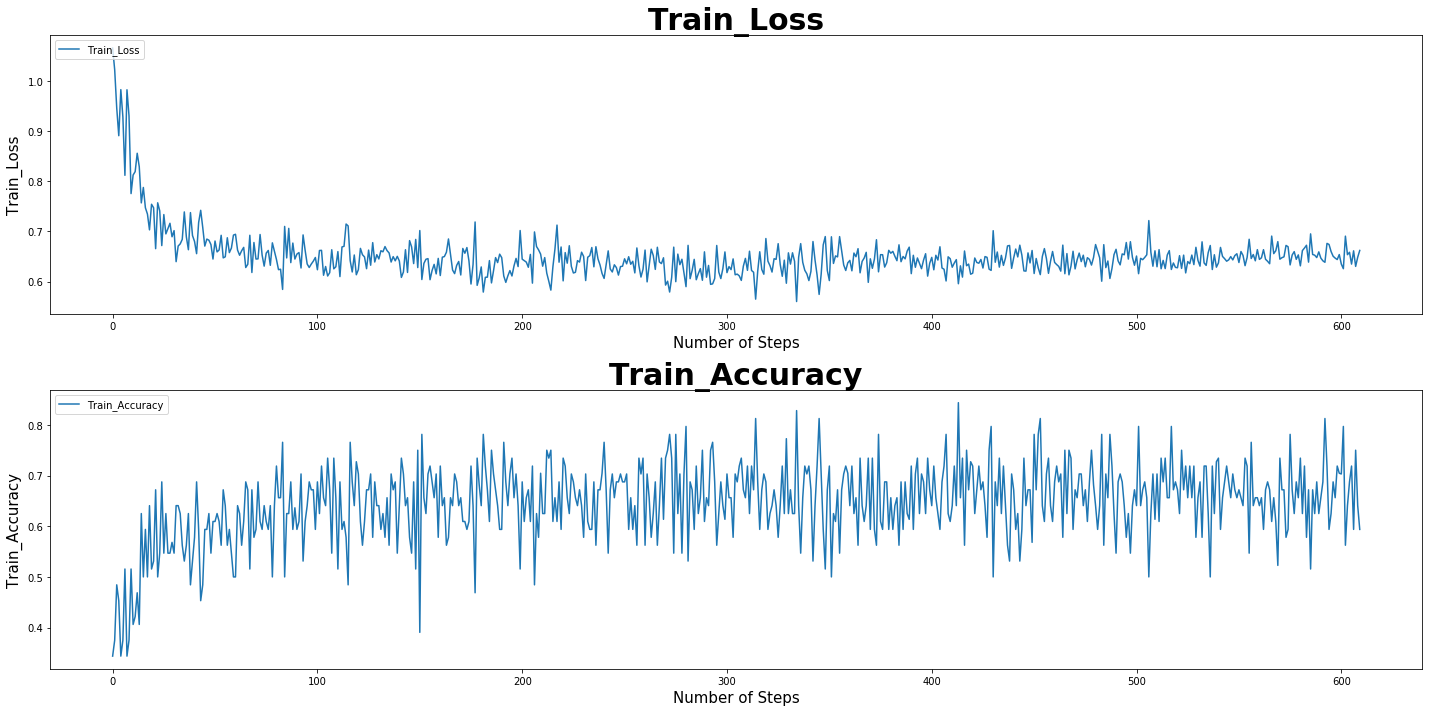

| Epoch [20] | Step [611] | lr [0.002000] | Loss: [0.6443] | Acc: [0.7188] | Time: 0.0s
| Epoch [20] | Step [612] | lr [0.002000] | Loss: [0.6597] | Acc: [0.6250] | Time: 0.0s
| Epoch [20] | Step [613] | lr [0.002000] | Loss: [0.6379] | Acc: [0.6875] | Time: 0.0s
| Epoch [20] | Step [614] | lr [0.002000] | Loss: [0.6468] | Acc: [0.7031] | Time: 0.0s
| Epoch [20] | Step [615] | lr [0.002000] | Loss: [0.6688] | Acc: [0.5938] | Time: 0.0s
| Epoch [20] | Step [616] | lr [0.002000] | Loss: [0.6401] | Acc: [0.7031] | Time: 0.0s
| Epoch [20] | Step [617] | lr [0.002000] | Loss: [0.6423] | Acc: [0.7031] | Time: 0.0s
| Epoch [20] | Step [618] | lr [0.002000] | Loss: [0.6505] | Acc: [0.6875] | Time: 0.0s
| Epoch [20] | Step [619] | lr [0.002000] | Loss: [0.6951] | Acc: [0.5156] | Time: 0.0s
| Epoch [20] | Step [620] | lr [0.002000] | Loss: [0.6469] | Acc: [0.6406] | Time: 0.0s


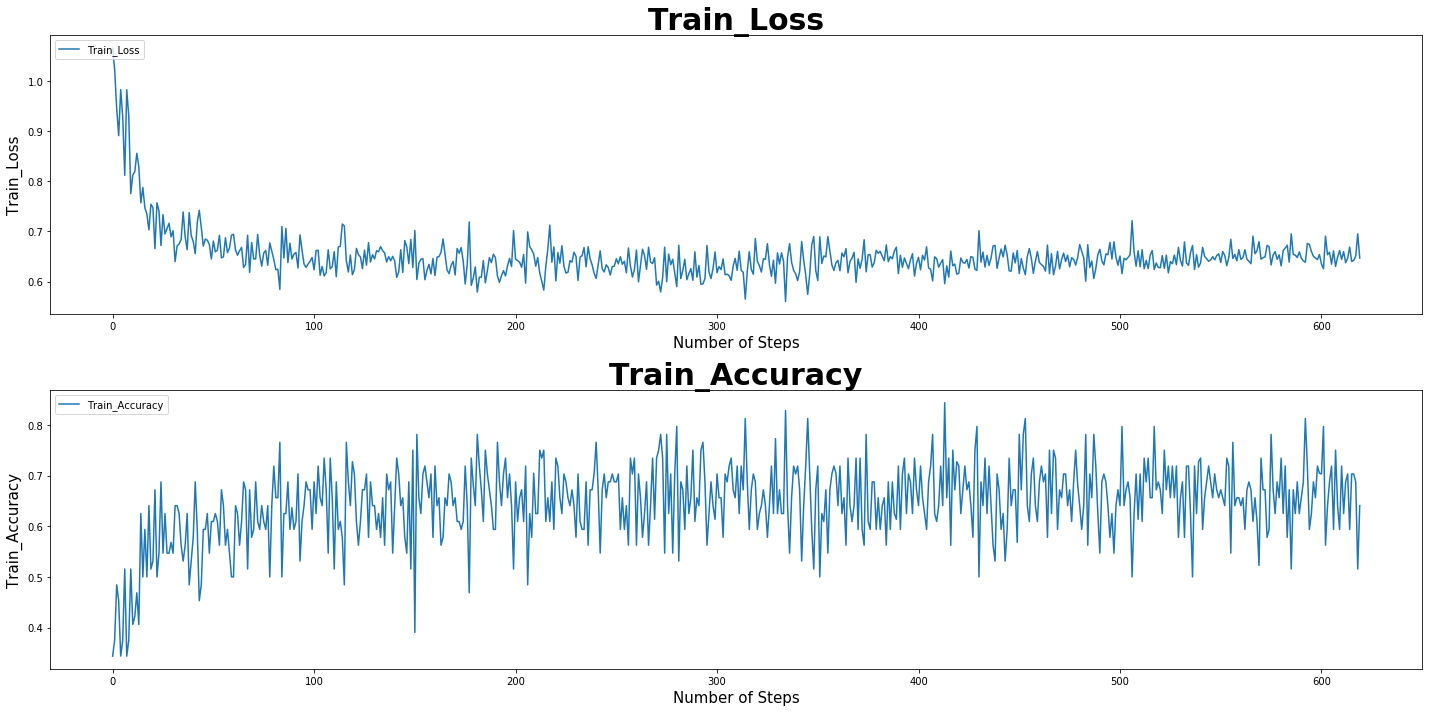

| Epoch [20] | Step [621] | lr [0.002000] | Loss: [0.6679] | Acc: [0.5938] | Time: 0.0s
| Epoch [20] | Step [622] | lr [0.002000] | Loss: [0.6460] | Acc: [0.6875] | Time: 0.0s
| Epoch [20] | Step [623] | lr [0.002000] | Loss: [0.6368] | Acc: [0.7344] | Time: 0.0s
| Epoch [20] | Step [624] | lr [0.002000] | Loss: [0.6353] | Acc: [0.7188] | Time: 0.0s


KeyboardInterrupt: 

In [49]:
while epoch < args.n_epoch:
    for i, (text, extra_info, length, label) in enumerate(train_loader):
        
        trainer.train()
        text, extra_info, length, label = text.to(device), extra_info.to(device), length.to(device), label.to(device)
        
        if trainer.optim.param_groups[0]['lr'] >= 0.00001:
            scheduler.step()
        start_t = time.time()
        trainer.train_step(((text, extra_info),length), label)
#         trainer.train_step((text, extra_info), label)

        end_t = time.time()
        allStep += 1
        print('| Epoch [%d] | Step [%d] | lr [%.6f] | Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
              (epoch, allStep, trainer.optim.param_groups[0]['lr'], trainer.loss.item(), trainer.accuracy.item(),
               end_t - start_t))

#         if trainer.accuracy.item() > 0.95: # Stop early
#             raise StopIteration
        if allStep % args.log_freq == 0:
            trainer.plot_train_hist(args.model_name)
            
        
        if args.earlyStopStep:
            if allStep >= args.earlyStopStep:
                    raise StopIteration
        

        if allStep % args.val_freq == 0:

            for _ in range(args.val_steps):
                trainer.eval()
                stIdx = np.random.randint(
                    0, len(validation_dataset) - args.batch_size)
                v_text, v_extra_info, v_len, v_label = validation_dataset[stIdx: stIdx +
                                                       args.batch_size]
                v_text, v_extra_info, v_len, v_label = v_text.to(device), v_extra_info.to(device), v_len.to(device), v_label.to(device)
                start_t = time.time()
                trainer.test_step(((text, extra_info),length), label)
#                 trainer.test_step((text, extra_info), label)
                end_t = time.time()
                print('| Epoch [%d] | Validation | Step [%d] |  Loss: [%.4f] | Acc: [%.4f] | Time: %.1fs' %
                      (epoch, allStep, trainer.loss.item(), trainer.accuracy.item(), end_t - start_t))
            trainer.calculateAverage()
            clear_output()
            print("TrainConfusion Matrix: \n")
            display(pd.DataFrame(trainer.cms['Train'][-1]))
            print("ValConfusion Matrix: \n")
            display(pd.DataFrame(trainer.cms['Val'][-1]))
            trainer.plot_all(args.model_name)
            
            
     # After every Epoch, if can be moved

    epoch += 1
    trainer.model_save(epoch)


    if args.earlyStopEpoch:
        if epoch >= args.earlyStopEpoch:
            raise StopIteration
